In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
#import cvxpy as cp

In [21]:
#向量的交叉项表示
#输入的是矩阵N*n维，N是样本数，n是特征数
def lvec(x):
    N,n = x.shape
    s=[]
    for i in range(N):
        for j in range(n):
            for k in range(j,n):         
                if k==j:
                    c=1/2*x[i,j]*x[i,j]
                    s.append(c)
                else:
                    c=x[i,j]*x[i,k]
                    s.append(c)
            
                
    s=np.array(s).reshape(N,-1)
    
              
    return s
#返回的也是N*m矩阵，m对应的是升维后列数

#产生G矩阵
def generateG(x):
    N,n = x.shape
    e=np.ones((N,1))
    s=lvec(x)
    z=np.hstack((s,x,e))
    eta=lvec(z)
    r=np.hstack((eta,s))
    G=np.hstack((r,x,e))
    return G

In [22]:
#定义人工数据集函数
def F_2x(x):
    y=abs(x-1)/4+abs(np.sin(np.pi*(1+(x-1)/4)+1))+1
    return y
N1=100 #总数据点


x_1= np.linspace(-5,5,N1)
#N个样本点，1维特征
x_1=x_1.reshape(-1,1)
y=F_2x(x_1)+0*np.random.randn(N1,1)
##随机注入离群值
for i in range(100):
    if i % 2==0:
        if np.random.random(1)>=0.5:
       
            y[i]+=0
        else:
            y[i]-=0

m=0.2
x_tr, x_te, y_tr, y_te = train_test_split(
    x_1,y, test_size=m, random_state=1)

In [23]:
#数据升维
z_1=np.hstack((x_1,x_1**3))
z_tr, z_te, y_tr, y_te = train_test_split(
    z_1,y, test_size=m, random_state=2)
#G是训练集+测试集
G=generateG(z_1)
#G_te是测试集
G_te=generateG(z_te)
#G_tr是测试集
G_tr=generateG(z_tr)

In [6]:
from coptpy import *

In [24]:
#利用CVXPY‘调用GUROBI’求解TWDWPSVR-1对偶问题
import cvxopt
import cvxpy as cp

#指明参数有助于调节参数以达到最优
C1 = 1
C2 = 100
nu1 = 0.1
lambda1 = 1
N1,l=G.shape
N=80
e=np.ones((N,1))
alpha1 = cp.Variable((N, 1))
r1 = cp.Variable((N, 1))
r11= cp.Variable((N, 1))
expr1 = 1/(2*lambda1)
expr2=lambda1*y_tr-(alpha1+(r11-r1))
expr3 = G_tr@np.linalg.inv(G_tr.T@G_tr+C1*np.identity(l, dtype=int))@G_tr.T
expr3 = cp.atoms.affine.wraps.psd_wrap(expr3)
expr4=alpha1+(r11-r1)
q=y_tr

objective = cp.Minimize((expr1)*cp.quad_form(expr2, expr3) + q.T @ expr4)
constraints = [0 <= alpha1, alpha1 <= C2*e/N,r1+r11<=1-lambda1,0 <= sum(alpha1), sum(alpha1) <= C2*nu1,0 <= r1, 0<=r11]
prob = cp.Problem(objective, constraints)
#results = prob.solve(solver=cp.GUROBI, verbose=True)
results = prob.solve(solver='COPT')

obj_val = []
obj_val.append(prob.objective.value)


#求解TWDWPSVR-2对偶问题

#指明参数有助于调节参数以达到最优
C3 = 1
C4 = 100
nu2 = 0.1
lambda2 = 1
N=80
e=np.ones((N,1))

r2 = cp.Variable((N, 1))
r21= cp.Variable((N, 1))
alpha2 = cp.Variable((N, 1))

expr11 = 1/(2*lambda2)
expr22=lambda2*y_tr+(alpha2+(r2-r21))
#expr2 = (lambda1*y-alpha1+e*(r-r1)).T
expr33= G_tr@np.linalg.inv(G_tr.T@G_tr+C1*np.identity(l, dtype=int))@G_tr.T
expr33 = cp.atoms.affine.wraps.psd_wrap(expr33)                                                                                                          
expr44=alpha2+(r2-r21)
q=-y_tr
# Matrix variable with shape (5, 1).


objective = cp.Minimize((expr11)*cp.quad_form(expr22, expr33) + q.T @ expr44)
# 定义约束条件
constraints = [0 <= alpha2, 
alpha2 <= C4*e/N,
r2+r21<=1-lambda2,
0 <= sum(alpha2),
sum(alpha2) <= C4*nu2,
0 <= r2, 0<=r21]

# 建⽴模型
prob = cp.Problem(objective, constraints)
# 模型求解
#results = prob.solve(solver=cp.GLPK_MI, verbose=True)
#results = prob.solve(solver=cp.GUROBI, verbose=True)
results = prob.solve(solver='COPT')
#print('问题的最优值为：{:.0f}'.format(prob.objective.value))


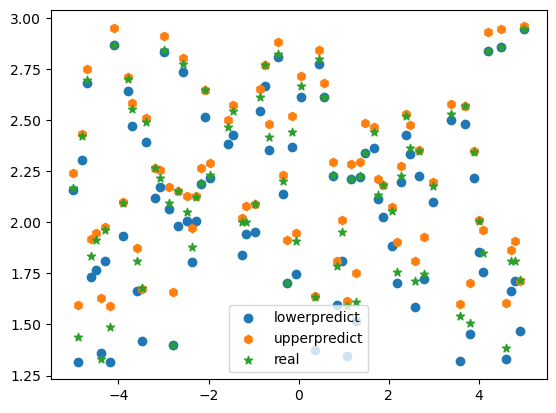

得分1: 0.9296317748082921
MSE1: 0.012215899604031974
得分2: 0.9552756451629073
MSE2: 0.007764132562055967


In [26]:

#训练过程使用交叉验证
##处理求解后的模型，在给定参数的情况下通过区间搜索参数值,给出要求的变量值
#可视化预测的结果，根据评价指标求得对应的值
a=expr2.value
u1=1/lambda1*np.linalg.inv(G_tr.T@G_tr+C1*np.identity(l, dtype=int))@G_tr.T@a
b=expr22.value
u2=1/lambda2*np.linalg.inv(G_tr.T@G_tr+C3*np.identity(l, dtype=int))@G_tr.T@b
y_hat1=G_tr@u1
y_hat2=G_tr@u2

plt.scatter(x_tr, y_hat1,marker="o",label="lowerpredict")
plt.scatter(x_tr, y_hat2,marker="h",label="upperpredict")
plt.scatter(x_tr, y_tr, marker='*',label="real")
plt.legend()
plt.show()

#测试过程

print("得分1:", r2_score(y_tr, y_hat1))
print("MSE1:", mean_squared_error(y_tr, y_hat1))


print("得分2:", r2_score(y_tr, y_hat2))
print("MSE2:", mean_squared_error(y_tr, y_hat2))
#列表格分析优劣性




In [18]:
#测试过程
#利用CVXPY‘调用GUROBI’求解TWDWPSVR-1对偶问题
import cvxopt
import cvxpy as cp

#指明参数有助于调节参数以达到最优
C1 = 1
C2 = 100
nu1 = 0.1
lambda1 = 0.1
N1,l=G.shape
N=20
e=np.ones((N,1))
alpha1 = cp.Variable((N, 1))
r1 = cp.Variable((N, 1))
r11= cp.Variable((N, 1))
expr1 = 1/(2*lambda1)
expr2=lambda1*y_te-(alpha1+(r11-r1))
expr3 = G_te@np.linalg.inv(G_te.T@G_te+C1*np.identity(l, dtype=int))@G_te.T
expr3 = cp.atoms.affine.wraps.psd_wrap(expr3)
expr4=alpha1+(r11-r1)
q=y_te

objective = cp.Minimize((expr1)*cp.quad_form(expr2, expr3) + q.T @ expr4)
constraints = [0 <= alpha1, alpha1 <= C2*e/N,r1+r11<=1-lambda1,0 <= sum(alpha1), sum(alpha1) <= C2*nu1,0 <= r1, 0<=r11]
prob = cp.Problem(objective, constraints)
#results = prob.solve(solver=cp.GUROBI, verbose=True)
results = prob.solve(solver='COPT')

obj_val = []
obj_val.append(prob.objective.value)


#求解TWDWPSVR-2对偶问题

#指明参数有助于调节参数以达到最优
C3 = 1
C4 = 100
nu2 = 0.13
lambda2 = 0.01
N=20
e=np.ones((N,1))

r2 = cp.Variable((N, 1))
r21= cp.Variable((N, 1))
alpha2 = cp.Variable((N, 1))

expr11 = 1/(2*lambda2)
expr22=lambda2*y_te+(alpha2+(r2-r21))
#expr2 = (lambda1*y-alpha1+e*(r-r1)).T
expr33= G_te@np.linalg.inv(G_te.T@G_te+C1*np.identity(l, dtype=int))@G_te.T
expr33 = cp.atoms.affine.wraps.psd_wrap(expr33)                                                                                                          
expr44=alpha2+(r2-r21)
q=-y_te
# Matrix variable with shape (5, 1).


objective = cp.Minimize((expr11)*cp.quad_form(expr22, expr33) + q.T @ expr44)
# 定义约束条件
constraints = [0 <= alpha2, 
alpha2 <= C4*e/N,
r2+r21<=1-lambda2,
0 <= sum(alpha2),
sum(alpha2) <= C4*nu2,
0 <= r2, 0<=r21]

# 建⽴模型
prob = cp.Problem(objective, constraints)
# 模型求解
#results = prob.solve(solver=cp.GLPK_MI, verbose=True)
#results = prob.solve(solver=cp.GUROBI, verbose=True)
results = prob.solve(solver='COPT')
#print('问题的最优值为：{:.0f}'.format(prob.objective.value))
a=expr2.value
u1=1/lambda1*np.linalg.inv(G_te.T@G_te+C1*np.identity(l, dtype=int))@G_te.T@a
b=expr22.value
u2=1/lambda2*np.linalg.inv(G_te.T@G_te+C3*np.identity(l, dtype=int))@G_te.T@b
y_hat1=G_te@u1
y_hat2=G_te@u2

print("得分1:", r2_score(y_te, y_hat1))
print("MSE1:", mean_squared_error(y_te, y_hat1))


print("得分2:", r2_score(y_te, y_hat2))
print("MSE2:", mean_squared_error(y_te, y_hat2))
y_hat_z=(y_hat1+y_hat2)/2
print("总得分:", r2_score(y_te,  y_hat_z))
print("总MSE:", mean_squared_error(y_te, y_hat_z))



得分1: 0.9998573908173825
MSE1: 2.121281715419116e-05
得分2: 0.9997589205580406
MSE2: 3.586006194028549e-05
总得分: 0.999904870450263
总MSE: 1.4150321231019537e-05


In [14]:
#封装函数，使训练过程通过接口调入
class DWPSVR:
    def __init__(self, x= 0.5):
        self.x = x
        self.multipler = None
    def fit(x, y):
        pass
    def predict(x, y):
        pass
    
    


In [10]:
class Vector:
    pass

In [2]:
v1 = Vector()

In [3]:
v1

In [4]:
v1.x = 1

In [5]:
v1.x

1

In [15]:
svr = DWPSVR(x=2)

In [16]:
svr

In [17]:
svr.x

2

In [18]:
svr2 = DWPSVR()

In [20]:
svr2.x

0.5

In [21]:
svr.multipler

In [1]:
from model.DWPSVR import DWPSVR

In [2]:
DWPSVR()

TypeError: __init__() missing 4 required positional arguments: 'C1', 'C2', 'nu1', and 'lambda1'

In [3]:
from model.DWPSVR import QSSVR

ImportError: cannot import name 'QSSVR' from 'model.DWPSVR' (C:\Users\DELL\Experiment-DWP\model\DWPSVR.py)